# LSTM baseline

from kuto

In [87]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [88]:
import os
import sys
import glob
import pickle
import random

In [89]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [90]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [10]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 56
IS_SAVE = True

utils.set_seed(SEED)

In [11]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [12]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_base25_withdelta.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000_base25_allwifibase_withdelta.csv')

In [13]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [14]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
DELTA_FEATS  = ['delta_x', 'delta_y']

In [15]:
bad_index = np.load('../54/output/oof54_badindex.npy')

In [16]:
train_df = train_df.drop(bad_index).reset_index(drop=True)

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [17]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61421
BSSID TYPES(test): 28283
BSSID TYPES(all): 89704


In [18]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 96
RSSI TYPES(test): 82
RSSI TYPES(all): 178


## PreProcess

In [19]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,DELTA_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    output_df.loc[:,DELTA_FEATS] = ss.transform(output_df.loc[:,DELTA_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id,delta_x,delta_y
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0,-0.025864,-0.014953
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5765,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5825,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,5765,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0,0.504875,0.397922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245037,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,0,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23,0.121380,0.362122
245038,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23,-2.383524,0.568957
245039,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd

In [20]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [21]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.delta_feats = df[DELTA_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx],
            'delta':self.delta_feats[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [22]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
        self.delta = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 2 * 64)
        )
        
        concat_size = 64 + (2 * NUM_FEATS * 64) + 64 * 2
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)
        
        x_delta = self.delta(x['delta'])


        x = torch.cat([x_bssid, x_delta, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [23]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [24]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [25]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [26]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [27]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 149.0709228515625


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 124.39849302083819


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 98.14117702930601


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 80.5741527853727


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 68.14028001628486


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 61.24592036848792


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 56.75345784953401


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 51.14571963844261


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 40.74353294824305


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 34.67109008786263


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 30.60422039799251


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 25.559302798979655


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 21.76845472885503


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 19.00511857234581


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 16.531717673172903


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 14.817722587175702


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 13.582724917723773


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 12.417541446361115


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.45834489201735


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 10.863945320585126


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.26755126504448


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.831470509424014


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.606857135272715


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 8.783443393746042


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 8.552437611132888


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.341216099267621


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.83816872900579


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.391296217771618


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 7.934192576369081


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.278737343450656


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 7.865340482547893


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 7.766308784498324


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 7.786803404867057


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.590845684398912


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 7.543030055813564


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 7.412069585049809


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 7.363062431603375


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.5139495438299635


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.377895984236679


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.388369228216367


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.469141618198065


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.415731147631612


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.865307221554267


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.055515510683783


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.289606364196555


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.203891888570442


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.446710810011425


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.131125157172334


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 6.687787927707359


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 6.580524296941473


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 6.5504234411636775


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 6.51881676457331


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.487374116694379


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 6.467689922791187


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.458581584430861


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.455614924498152


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.431317150363969


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.424626223702579


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.419084583362859


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.424842155870814


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.42034856585387


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.408052601734582


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.443309358438071


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.439852796380543


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.405484991075762


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.382169311750064


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.375830185122607


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.357524695812095


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.377164598362556


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.369436276711476


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.388564380075927


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.370093263039583


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.3459512530855475


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.338428535630764


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.335737280668766


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.333602227304255


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.331160562619392


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.329233526261464


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.3254473182997835


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.3298375253458765


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.3316089709869035


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.334663076714933


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.331939531656784


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.32910237944573


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.3349648031600445


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.328936793717749


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.328049038530957


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.333942950996819
fold 0: mean position error 6.328562450884773
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,30.12212
Loss/xy,30.12212
Loss/floor,5.32509
MPE/val,6.32856
epoch,86
trainer/global_step,33320
_runtime,426
_timestamp,1619865878
_step,86


Loss/val,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▃▅▅▆▇▅▆▆▇▇█████████████████████████████
MPE/val,█▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 155.75538635253906


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 135.78282349994836


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 112.11775287886191


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 96.157849979756


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 86.77332600404684


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 82.03521102349178


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 80.13233747381075


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 79.6500372745588


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 63.58731898005846


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 51.72664528032521


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 43.78734476208795


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 35.57657956161689


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 26.56195985126732


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 21.32333584506714


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 18.38467943727593


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 15.421149574482667


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 13.541573259457877


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 12.76915956826337


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.708298802160419


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.127198368135936


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.237854721638783


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.310290774449962


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.70157315122349


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.247651663401047


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.349403686882034


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 8.811384810139815


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.569489649910052


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.348673955346403


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.333879797425803


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 10.641149523471968


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.004522495261162


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 7.933726339953487


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 7.775804472836484


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 7.640318506064992


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.580096824180465


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 7.793639893898472


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.100461073576488


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.4258229932272455


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.276673392349789


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.326937195408313


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.312945454774295


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.425130862328741


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.609163922615276


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.486653849038329


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.302292066322541


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 6.724778042643481


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 6.64855793691909


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 6.631855428252494


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 6.609801803568299


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 6.62647086442486


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 6.616135843582754


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 6.582362790808229


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.5982392478495315


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 6.593027523849177


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.596579977180792


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.567990873894018


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.592694892604392


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.592385940213352


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.597891951843006


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.5829753777468225


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.559471920247055


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.548185177584866


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.551050695583103


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.54635717098575


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.548083852744361


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.542614654769959


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.5378089425067385


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.537780211957435


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.550266949532262


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.5430129358735085


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.538576921904098


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.538393838652482


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.536885878904079


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.536023139973804


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.5419453975307915


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.542562480083757


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.544166725933175


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.5390734499574465


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.535061977608525


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.535655944664519


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.531936930373056


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.53667666647977


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.5381735419920135


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.53500381226516


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.5362288806092765


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.54187841040386


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.536873516270785


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.539162640339529


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.535690872629645


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.534652007331478


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.534612453430756
fold 1: mean position error 6.524002921504819
Fold 2


Loss/val,32.0477
Loss/xy,32.0477
Loss/floor,4.57151
MPE/val,6.524
epoch,89
trainer/global_step,34469
_runtime,442
_timestamp,1619866328
_step,89


Loss/val,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁█▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
MPE/val,█▆▅▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 138.82231903076172


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 126.3423411967098


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 101.12378217863


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 87.12970297232918


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 80.94662182918493


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 79.04778017513995


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 78.9000340786533


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 79.15714735224627


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 79.35187011179717


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 79.44088853269383


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 54.30055204163427


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 50.60505591095358


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 48.938977127489835


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 47.35631313531295


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 46.546465713044874


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 45.86470160795295


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 34.026176463866584


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 24.86713748673598


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 20.067948113533035


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 16.76410489151443


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 14.710755211719567


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 12.9561486142701


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.916101050981576


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.864013465850249


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.40009739195955


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 11.864784488643425


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.139401035680287


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.026902803260347


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.948185695038326


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.534929535959078


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.288903586674428


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.323503862472547


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 7.897417409264523


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 7.811599760167841


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.07588581006596


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 7.768768779825474


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 7.570571308550627


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.606429322258286


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.763916041540063


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 9.04168234506379


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.446400313921597


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.252130915073381


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.144363586669383


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.464685602680497


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.1034278742213175


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 6.999768041614172


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.073165401168492


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.545142363378967


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.062028790945592


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.0309220297613


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.1149580282145655


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.307378687720369


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.753969788983248


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.308544683715573


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.793313814894013


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.653272994618486


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.587615075534669


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.568334151869235


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.5322502227365105


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.49690774558247


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.494594623213229


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.466246659125107


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.463019547471101


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.472024255904599


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.449508340678353


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.4412044437899105


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.462474795139355


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.44432544881019


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.431942642814871


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.438907281212185


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.432189684091271


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.396737046647762


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.414397576256938


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.433853207291037


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.423481705612031


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.395165955674821


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.413574106235434


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.413302395006885


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.415873471161594


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.403674181928669


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.375135578431081


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.366830148774645


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.359745560564857


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.35862392834995


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.366326784094174


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.36379914590414


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.355574377528999


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.364253417629263


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.34997865287722


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.352958251384721


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.3509922649549395


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.354997014005979


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.359711695516455


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.351123603681724


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.350949703675249


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.346090996934883


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.353243224214817


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.35069004478662


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.3534650305906935


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.3533959157656925


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.346294241754904


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.3535675490679955


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.348402232795522


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.34845974393513


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.34807872923388


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.347583341425744


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.347736740673798


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.35630885090517


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.3474388887052955


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.348312778641348


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 6.350250308928282


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.350759127109811


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 6.3489089897577315


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.34950465331043


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 6.3513025187927745


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 6.351806771820006


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 6.350279902418454


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 6.352249011397362


Validating: 0it [00:00, ?it/s]

epoch = 117, mpe_loss = 6.3466920160513


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 6.350289761480215


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 6.349354105043239


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 6.349276282865069


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 6.3529847242693975


Validating: 0it [00:00, ?it/s]

epoch = 122, mpe_loss = 6.3534151944129365


Validating: 0it [00:00, ?it/s]

epoch = 123, mpe_loss = 6.349777436342792


Validating: 0it [00:00, ?it/s]

epoch = 124, mpe_loss = 6.3486248374633165


Validating: 0it [00:00, ?it/s]

epoch = 125, mpe_loss = 6.349207539057386


Validating: 0it [00:00, ?it/s]

epoch = 126, mpe_loss = 6.3479184439216825


Validating: 0it [00:00, ?it/s]

epoch = 127, mpe_loss = 6.34704601375953


Validating: 0it [00:00, ?it/s]

epoch = 128, mpe_loss = 6.350823947161004


Validating: 0it [00:00, ?it/s]

epoch = 129, mpe_loss = 6.351335072754949


Validating: 0it [00:00, ?it/s]

epoch = 130, mpe_loss = 6.347726769205454


Validating: 0it [00:00, ?it/s]

epoch = 131, mpe_loss = 6.3503954911577525


Validating: 0it [00:00, ?it/s]

epoch = 132, mpe_loss = 6.346143870789935


Validating: 0it [00:00, ?it/s]

epoch = 133, mpe_loss = 6.352444359789724


Validating: 0it [00:00, ?it/s]

epoch = 134, mpe_loss = 6.349346429973409


Validating: 0it [00:00, ?it/s]

epoch = 135, mpe_loss = 6.349758878350258


Validating: 0it [00:00, ?it/s]

epoch = 136, mpe_loss = 6.347175815399143


Validating: 0it [00:00, ?it/s]

epoch = 137, mpe_loss = 6.348338333700878


Validating: 0it [00:00, ?it/s]

epoch = 138, mpe_loss = 6.348587699450444


Validating: 0it [00:00, ?it/s]

epoch = 139, mpe_loss = 6.351072014134


Validating: 0it [00:00, ?it/s]

epoch = 140, mpe_loss = 6.347671547985596


Validating: 0it [00:00, ?it/s]

epoch = 141, mpe_loss = 6.349210450938647


Validating: 0it [00:00, ?it/s]

epoch = 142, mpe_loss = 6.3469261254953295


Validating: 0it [00:00, ?it/s]

epoch = 143, mpe_loss = 6.34921118768229


Validating: 0it [00:00, ?it/s]

epoch = 144, mpe_loss = 6.349179580699707


Validating: 0it [00:00, ?it/s]

epoch = 145, mpe_loss = 6.35172026226486


Validating: 0it [00:00, ?it/s]

epoch = 146, mpe_loss = 6.351537702308185


Validating: 0it [00:00, ?it/s]

epoch = 147, mpe_loss = 6.352443095998488


Validating: 0it [00:00, ?it/s]

epoch = 148, mpe_loss = 6.3500075529235


Validating: 0it [00:00, ?it/s]

epoch = 149, mpe_loss = 6.350406505815361


Validating: 0it [00:00, ?it/s]

epoch = 150, mpe_loss = 6.35260136835817


Validating: 0it [00:00, ?it/s]

epoch = 151, mpe_loss = 6.346987059798793


Validating: 0it [00:00, ?it/s]

epoch = 152, mpe_loss = 6.348563214467056


Validating: 0it [00:00, ?it/s]

epoch = 153, mpe_loss = 6.348511162335458


Validating: 0it [00:00, ?it/s]

epoch = 154, mpe_loss = 6.349111351306024


Validating: 0it [00:00, ?it/s]

epoch = 155, mpe_loss = 6.35299603295499


Validating: 0it [00:00, ?it/s]

epoch = 156, mpe_loss = 6.348814751574959
fold 2: mean position error 6.342813217359603
Fold 3


Loss/val,30.35146
Loss/xy,30.35146
Loss/floor,5.45581
MPE/val,6.34281
epoch,156
trainer/global_step,60130
_runtime,762
_timestamp,1619867097
_step,156


Loss/val,█▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▅▇▇▇█████████████████████████████████
MPE/val,█▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 143.48529052734375


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 126.10775877686514


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 99.80038467956626


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 87.07338432816492


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 71.17917412864989


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 62.5450305264929


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 57.67086586874464


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 54.68118042444837


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 52.69633756297222


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 50.715033408524334


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 49.67908905986426


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 46.07160001431686


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 33.91389889950337


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 26.9782331754332


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 21.620205788508702


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 18.37543134153753


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 16.006898351769518


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 13.924155119104661


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.750479934440143


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.710911339175874


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.280956104829691


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.231881258496339


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.693455914440362


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.591684802718785


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.133895541230837


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 8.815203036303105


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.6527450516604


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.801148850416793


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.248934810576232


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.292231557809787


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.293516786634058


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.247336326086002


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.657196495843971


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.015182345889617


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.104607467418132


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 7.936606242820837


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 7.624557214154713


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.388915576148723


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.89891984410908


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.42624004509138


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.466265533281409


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.038267899898516


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.430076499348101


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.3268715110809906


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.312604324973148


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.4226540875607645


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.920841017063114


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.513454221512961


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 6.826919146853945


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 6.723353730379671


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 6.663835919205693


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 6.654603250000787


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.609629104318826


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 6.58111615759739


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.575626448876616


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.565207334748213


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.546958203333012


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.557472774515982


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.556289840219677


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.535182646651198


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.535877434671789


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.518843678460605


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.514060461866683


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.497451558277227


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.5265200166166695


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.506473998876586


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.499567420802254


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.5166691831056625


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.478489814029224


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.480562040339346


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.4905002730480135


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.478054228684177


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.484739386733028


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.442514844346737


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.43617431430713


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.4384174405232715


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.431476082274879


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.4312457308389135


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.4310805862364555


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.428745596737102


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.435202946481497


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.428022612696108


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.423177266898363


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.432025802308234


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.424300306733104


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.418113789912584


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.419733565354693


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.427507233360539


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.425953836112782


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.431103141195532


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.4226436668979945


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.420901707117108


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.421897924032764


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.422517294901005


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.418450235888578


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.4213395328193466


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.422539572352949


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.419131918229919


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.42347161795782


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.416953730626382


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.424055013751638


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.42043574154377


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.421627039710681


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.4221615603436595


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.420940850092017


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.421901726852293
fold 3: mean position error 6.4214961418877365
Fold 4


Loss/val,31.57465
Loss/xy,31.57465
Loss/floor,5.46633
MPE/val,6.4215
epoch,104
trainer/global_step,40214
_runtime,525
_timestamp,1619867630
_step,104


Loss/val,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▇▆██▇▆▂▂▁▂▁▂▁▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 147.02092742919922


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 135.3756154084551


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 112.03090323140657


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 94.92532912371814


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 77.86497537554175


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 67.64579325741616


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 61.470330263393514


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 56.458424179450326


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 51.24435817288315


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 41.14493809446045


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 34.64430517390154


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 29.16260829049608


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 25.010828060300454


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 21.700202501770377


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 18.888262623030204


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 16.779948861918587


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 15.047010574219883


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 13.725890755869338


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.524069235592648


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 13.2388229218946


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.079391534561696


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.296805973286213


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.131438193329865


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.441915839046672


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.341689392276432


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 8.867291780269666


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.525697933159012


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.418738331915675


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.33611963343793


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.42179037047469


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.113945892539578


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 7.788366879458013


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 7.790266725248185


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 7.811518559853236


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.232708399926407


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 7.660187262987745


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 7.6374528744946355


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.710090400300164


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.515230638393457


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.43655187625816


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.106617605124694


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.258777775842211


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.502913263180981


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.016737947213477


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.1091705051021306


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.18465073471484


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.2838625093733045


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.215491071343422


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 6.557260674950869


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 6.486690321478291


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 6.431698650769565


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 6.412045560453248


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.392065179304801


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 6.376783822433673


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.37162627560505


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.360851337728293


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.348438837174055


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.389301602607188


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.390955644025318


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.337950896741687


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.357349788797074


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.3615650068158685


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.372588990391165


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.342400827593561


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.30918020290741


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.299971270388451


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.296735308740449


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.294251398547836


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.299592842442402


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.29741990501466


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.296199574742627


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.286236796906029


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.29063908431841


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.290713193191998


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.28584515940452


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.293523277277532


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.28780608224696


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.292153399059738


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.289117833086546


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.292091052493324


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.292946531504825


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.28789769847324


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.2892883030184805


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.286921402250511


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.287841815015544


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.292844205014948


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.2935707569122314


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.288022499909435


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.287548353490622


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.292829463231391


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.291158287961413


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.290574815610181
fold 4: mean position error 6.2868358732826755


In [73]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,163.442764,103.012230,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,164.793655,104.761871,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,163.465347,112.593491,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,163.224701,108.837540,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,163.640579,111.778992,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
245037,194.185898,142.385605,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245038,187.050934,144.252808,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245039,186.821060,144.640808,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245040,187.434647,141.658844,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [29]:
oofs_df_dupli = oofs_df[~oofs_df.duplicated(subset='timestamp')].sort_values('timestamp').reset_index(drop=True)

In [30]:
oofs_df_dupli[['path', 'timestamp', 'site']]

,path,timestamp,site
0,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b
1,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b
2,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b
3,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b
4,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b
...,...,...,...
69804,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266
69805,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266
69806,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266
69807,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266


In [31]:
oofs_df_gby = oofs_df.groupby('timestamp').mean()[['x', 'y']].sort_index().reset_index(drop=True)
oofs_df_gby[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']] = oofs_df_dupli[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']]
oofs_df_gby.to_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv", index=False)
oofs_df_gby

,x,y,path,timestamp,site,site_path_timestamp,floor
0,164.065933,37.911411,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
1,189.972687,31.995396,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
2,194.028137,89.345505,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
3,187.890717,86.361153,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
4,185.335983,87.205338,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0
...,...,...,...,...,...,...,...
69804,66.942741,178.335876,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69805,61.808079,179.218323,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69806,49.804398,181.575562,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69807,43.907192,182.643234,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0


In [32]:
train_df_gby = train_df.groupby('wp_tmestamp').mean()[['x', 'y']]

In [33]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
oofs_score_gby = mean_position_error(
        oofs_df_gby['x'], oofs_df_gby['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}, CV_gby:{oofs_score_gby}")

CV:6.380742492679918, CV_gby:6.0245324954278665


In [34]:
fold_mean_xy = 0
for i in range(len(predictions)):
    fold_mean_xy += predictions[i][['x', 'y']]
fold_mean_xy = fold_mean_xy / 5
fold_mean_xy

,x,y
0,65.457954,81.340286
1,68.417610,81.823753
2,67.826309,80.673386
3,68.774765,81.988380
4,68.733971,79.926285
...,...,...
37395,129.924850,184.627350
37396,132.656067,181.837646
37397,131.737350,179.215164
37398,129.827835,174.165558


In [35]:
fold_mean_xy['site_path_timestamp'] = predictions[0]['site_path_timestamp']

In [36]:
all_preds = fold_mean_xy.groupby('site_path_timestamp').mean()

In [37]:
# all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
# all_preds

In [38]:
all_preds_50 = pd.read_csv('../50/output/sub50.csv', index_col=0)
all_preds_50.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_50

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.71397,104.649240
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.89932,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.22545,105.812570
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.35129,107.935360
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.31835,108.258490
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,210.10178,100.415660
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.61255,101.582490
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,205.28879,106.346170


In [39]:
all_preds_merge = pd.merge(all_preds_50, all_preds, how='left', on='site_path_timestamp')[['floor', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'x_y': 'x', 'y_y': 'y'})
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,NaN,NaN
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,208.537460,99.446541
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,209.327209,100.500992
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,202.109131,107.851929


In [40]:
all_preds_merge['floor'].fillna(all_preds_50['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_50['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_50['y'], inplace=True)
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,208.537460,99.446541
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,209.327209,100.500992
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,202.109131,107.851929


In [41]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,208.537460,99.446541
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,209.327209,100.500992
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,202.109131,107.851929


In [42]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,208.537460,99.446541
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,209.327209,100.500992
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,202.109131,107.851929


# Post Proccess

In [43]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [44]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [45]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

In [46]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [47]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [48]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [49]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [50]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 28319.54it/s]


In [51]:
sub_df['txt_path'] = txt_pathes

In [52]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [02:24,  4.33it/s]


In [53]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

100%|██████████| 69809/69809 [00:40<00:00, 1710.05it/s]


In [54]:
oofs_df['txt_path'] = txt_pathes

In [55]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

10753it [16:44, 10.70it/s]


,site_path_timestamp,floor,x,y
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,164.953058,39.017828
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,189.085562,30.888978
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,197.411458,89.688007
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,184.507402,86.018648
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,182.703022,87.096392
...,...,...,...,...
69804,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,65.815202,177.279163
69805,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,60.448644,179.027113
69806,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,51.526477,181.672129
69807,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,46.096390,183.970858


In [56]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv", index=False)

In [57]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:4.961944372937081


In [58]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [59]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv")

In [60]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [61]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [62]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [63]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [64]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [65]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [66]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [67]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.162830,104.450550,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,192.553130,111.863014,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [68]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [69]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,163.710890,36.197370,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,189.085562,30.888978,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,195.909590,90.654030,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,185.099150,88.624350,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,185.099150,88.624350,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,F3
...,...,...,...,...,...,...,...
69804,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,68.407646,177.942440,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
69805,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,61.413883,176.395230,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
69806,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,54.303120,178.365650,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
69807,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,49.308346,187.129460,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1


In [70]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:4.405280909162124


In [71]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp_gby.csv", index=False)

In [72]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,28.75554
Loss/xy,28.75554
Loss/floor,4.43593
MPE/val,6.28684
epoch,90
trainer/global_step,34852
_runtime,457
_timestamp,1619868095
_step,90


Loss/val,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▅▁████████████████████████████████████
MPE/val,█▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,4.40528
_runtime,2
_timestamp,1619869380
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [ ]:
import matplotlib.pylab as plt

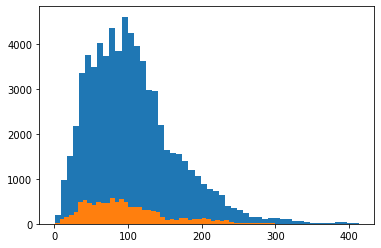

In [86]:
plt.hist(np.abs(oofs_pp['x'].values), bins=50)
plt.hist(np.abs(sub_pp['x'].values), bins=50)
plt.show()

In [84]:
pd.DataFrame(np.abs(oofs_pp['x'].values)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,69809.0,112.689857,66.305873,0.184819,59.125371,101.573235,159.72145,329.78467


In [85]:
pd.DataFrame(np.abs(sub_pp['x'].values)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,10133.0,100.25362,59.953726,3.3604,53.489666,86.27646,138.38644,285.74164


In [78]:
bad_index = np.union1d(np.where(np.abs(train_df['x'].values - oofs_df['x']) > 20)[0], np.where(np.abs(train_df['y'].values - oofs_df['y']) > 20)[0])

In [92]:
np.save(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_badindex.npy", bad_index)

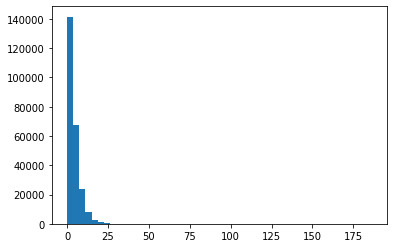

,count,mean,std,min,25%,50%,75%,max
x,245042.0,4.067969,3.780431,0.000015,1.41157,3.084192,5.611626,186.191399


In [76]:
plt.hist(np.abs(train_df['x'].values - oofs_df['x']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['x'].values - oofs_df['x'])).describe().T

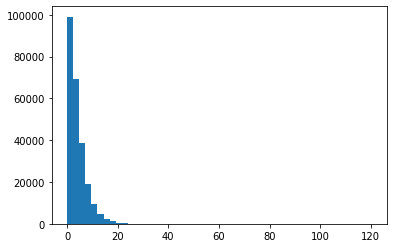

,count,mean,std,min,25%,50%,75%,max
y,245042.0,4.053767,3.723929,0.000053,1.423114,3.092892,5.588755,120.228602


In [77]:
plt.hist(np.abs(train_df['y'].values - oofs_df['y']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['y'].values - oofs_df['y'])).describe().T

In [ ]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

In [ ]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)